In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import glob as glob
from pickle import load

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# CO Historical precerature (F) and Precipitation (inch/day)
hist = pd.DataFrame()
for file in glob.glob('data/climate/*.parquet'):
    hist = pd.concat([hist, pd.read_parquet(file)])

hist = hist.groupby('date', as_index=False)[['avgtempf','precpinch']].mean()
hist_end_date = hist['date'].max()

In [3]:
# CO RCP Temperature

rcp45_temp = pd.DataFrame()
for file in glob.glob('data/scenarios/rcp45_temp*.parquet'):
    rcp45_temp = pd.concat([rcp45_temp, pd.read_parquet(file)])

rcp45_temp['tempf'] = rcp45_temp['temp'] * 9/5 + 32

rcp85_temp = pd.DataFrame()
for file in glob.glob('data/scenarios/rcp85_temp*.parquet'):
    rcp85_temp = pd.concat([rcp85_temp, pd.read_parquet(file)])

rcp85_temp['tempf'] = rcp85_temp['temp'] * 9/5 + 32

In [4]:
# CO RCP Precipitation

rcp45_prec = pd.DataFrame()
for file in glob.glob('data/scenarios/rcp45_prec*.parquet'):
    rcp45_prec = pd.concat([rcp45_prec, pd.read_parquet(file)])

rcp45_prec['precinch'] = rcp45_prec['prec'] / 25.4 

rcp85_prec = pd.DataFrame()
for file in glob.glob('data/scenarios/rcp85_prec*.parquet'):
    rcp85_prec = pd.concat([rcp85_prec, pd.read_parquet(file)])

rcp85_prec['precinch'] = rcp85_prec['prec'] / 25.4

## RCP 4.5 Scenario based projections

In [5]:
rcp45 = rcp45_temp[['time','tempf']].merge(rcp45_prec[['time', 'precinch']], on=['time'])

rcp45['day_date'] = rcp45['time'].dt.date

rcp45 = rcp45[rcp45['day_date'] >= pd.to_datetime('2024-01-01').date()]

rcp45.drop(columns=['time'], inplace=True)

rcp45 = rcp45.groupby('day_date').mean().reset_index()

In [6]:
engineered_features = ['precpinch_14d', 'precpinch_7d', 'avgtempf_7d', 'precpinch_1d_lag', 'avgtempf_1d_lag']

# Function for generating engineered features

def perform_feature_engineering(df):
    df['precpinch_14d'] = df['precinch'].rolling(14).mean() # 14 day rolling mean for precpinch
    df['precpinch_7d'] = df['precinch'].rolling(7).mean() #7 day rolling mean for precpinch
    df['avgtempf_7d'] = df['tempf'].rolling(7).mean() # 7 day rolling mean for avgtempf
    df['precpinch_1d_lag'] = df['precinch'].shift(1) # 1 day lag for precpinch
    df['avgtempf_1d_lag'] = df['tempf'].shift(1) # 1 day lag for avgtempf
    df = df.dropna(axis=0) # drop rows with missing values
    return df


rcp45 = perform_feature_engineering(rcp45)

day_date = rcp45['day_date'].values

### Muddy Creek model based projections

2023-12-18 09:49:17.614856: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-18 09:49:17.614882: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-18 09:49:17.614896: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-18 09:49:17.614934: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-18 09:49:17.614947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


 57/871 [>.............................] - ETA: 1s

2023-12-18 09:49:17.879961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


871/871 [==============================] - 2s 2ms/step


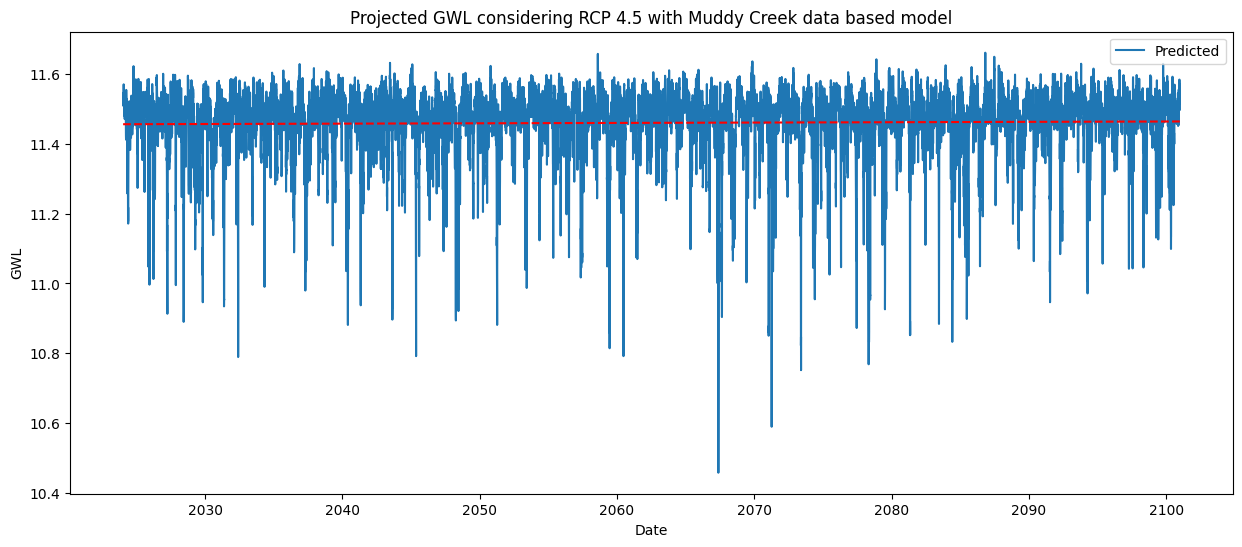

In [7]:

x = rcp45[engineered_features].values

# load the scaler
sc_climate = load(open('model/sc_climate_muddy_creek.pkl', 'rb'))

x_transformed = sc_climate.transform(x)

# load the model
model = tf.keras.models.load_model('model/final_model_muddy_creek.h5')

y_pred = model.predict(x_transformed)

y_pred = [y[0] for y in y_pred]

df_projection = pd.DataFrame({'day_date': day_date, 'gwl': y_pred})

df_projection['day_date'] = pd.to_datetime(df_projection['day_date'])

trend_line = np.poly1d(np.polyfit(mdates.date2num(df_projection['day_date']), df_projection['gwl'], 1))

plt.figure(figsize=(15, 6))
plt.plot(df_projection['day_date'], df_projection['gwl'], label='Predicted')
plt.plot(mdates.date2num(df_projection['day_date']), trend_line(mdates.date2num(df_projection['day_date'])), "r--")
plt.title('Projected GWL considering RCP 4.5 with Muddy Creek data based model')
plt.xlabel('Date')
plt.ylabel('GWL')
plt.legend()
plt.show()

871/871 [==============================] - 2s 2ms/step


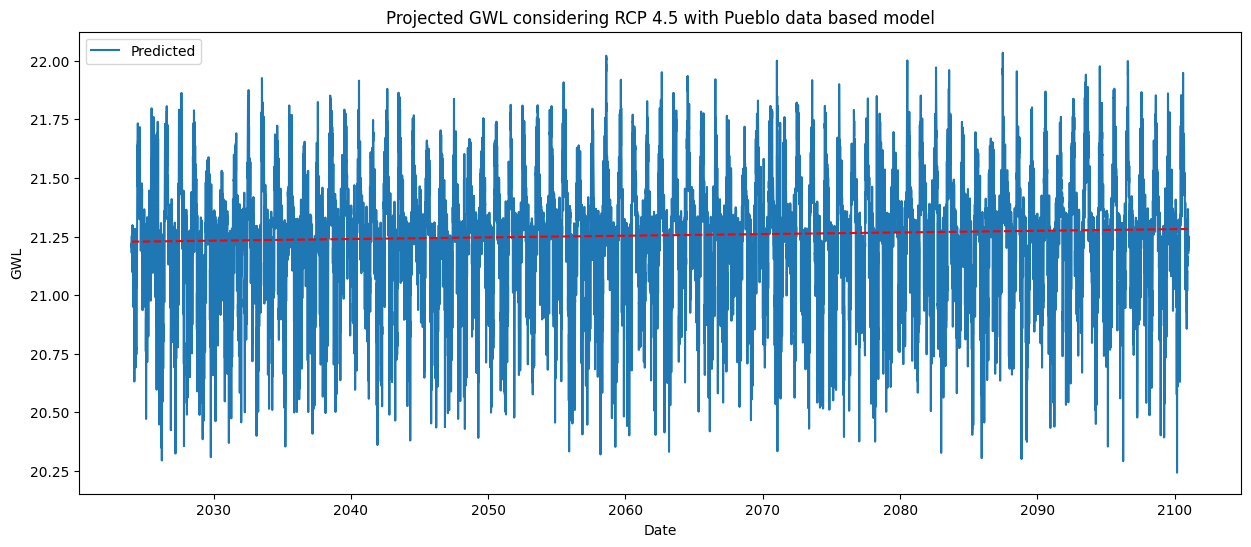

In [10]:

# load the scaler
sc_climate = load(open('model/sc_climate_pubelo.pkl', 'rb'))

x_transformed = sc_climate.transform(x)

# load the model
model = tf.keras.models.load_model('model/final_model_pueblo.h5')

y_pred = model.predict(x_transformed)

y_pred = [y[0] for y in y_pred]

df_projection = pd.DataFrame({'day_date': day_date, 'gwl': y_pred})

df_projection['day_date'] = pd.to_datetime(df_projection['day_date'])

trend_line = np.poly1d(np.polyfit(mdates.date2num(df_projection['day_date']), df_projection['gwl'], 1))

plt.figure(figsize=(15, 6))
plt.plot(df_projection['day_date'], df_projection['gwl'], label='Predicted')
plt.plot(mdates.date2num(df_projection['day_date']), trend_line(mdates.date2num(df_projection['day_date'])), "r--")
plt.title('Projected GWL considering RCP 4.5 with Pueblo data based model')
plt.xlabel('Date')
plt.ylabel('GWL')
plt.legend()
plt.show()

## RCP 8.5 Scenario based projections

In [11]:
rcp85 = rcp85_temp[['time','tempf']].merge(rcp85_prec[['time', 'precinch']], on=['time'])

rcp85['day_date'] = rcp85['time'].dt.date

rcp85 = rcp85[rcp85['day_date'] >= pd.to_datetime('2024-01-01').date()]

rcp85.drop(columns=['time'], inplace=True)

rcp85 = rcp85.groupby('day_date').mean().reset_index()

In [12]:
rcp85 = perform_feature_engineering(rcp85)

day_date = rcp45['day_date'].values

### Muddy Creek based projection

871/871 [==============================] - 2s 2ms/step


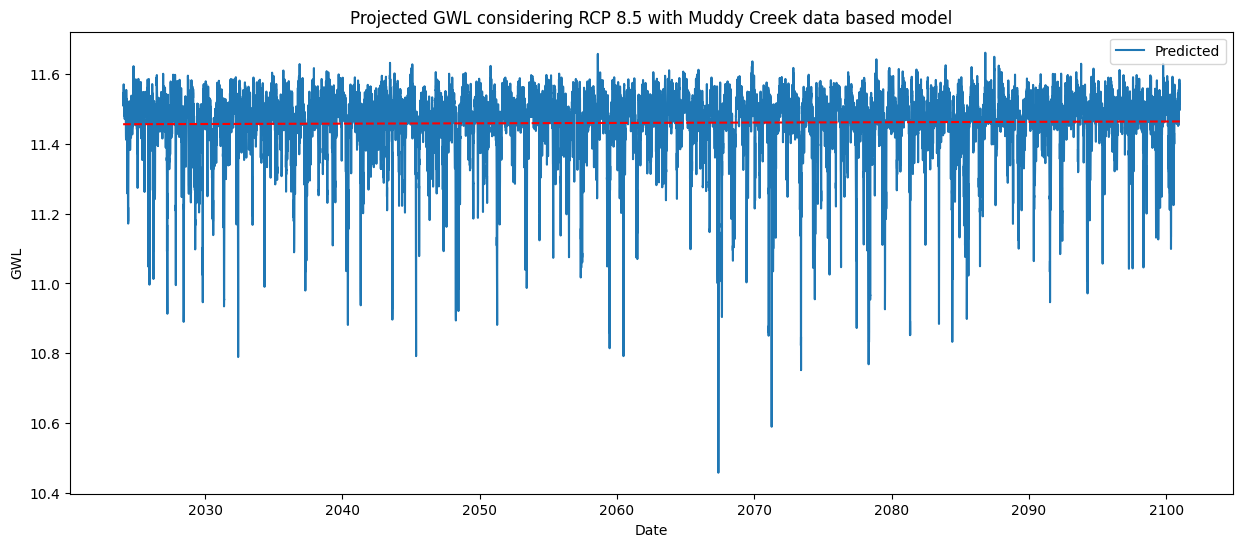

In [13]:

x = rcp45[engineered_features].values

# load the scaler
sc_climate = load(open('model/sc_climate_muddy_creek.pkl', 'rb'))

x_transformed = sc_climate.transform(x)

# load the model
model = tf.keras.models.load_model('model/final_model_muddy_creek.h5')

y_pred = model.predict(x_transformed)

y_pred = [y[0] for y in y_pred]

df_projection = pd.DataFrame({'day_date': day_date, 'gwl': y_pred})

df_projection['day_date'] = pd.to_datetime(df_projection['day_date'])

trend_line = np.poly1d(np.polyfit(mdates.date2num(df_projection['day_date']), df_projection['gwl'], 1))

plt.figure(figsize=(15, 6))
plt.plot(df_projection['day_date'], df_projection['gwl'], label='Predicted')
plt.plot(mdates.date2num(df_projection['day_date']), trend_line(mdates.date2num(df_projection['day_date'])), "r--")
plt.title('Projected GWL considering RCP 8.5 with Muddy Creek data based model')
plt.xlabel('Date')
plt.ylabel('GWL')
plt.legend()
plt.show()

### Pueblo based projection

871/871 [==============================] - 2s 2ms/step


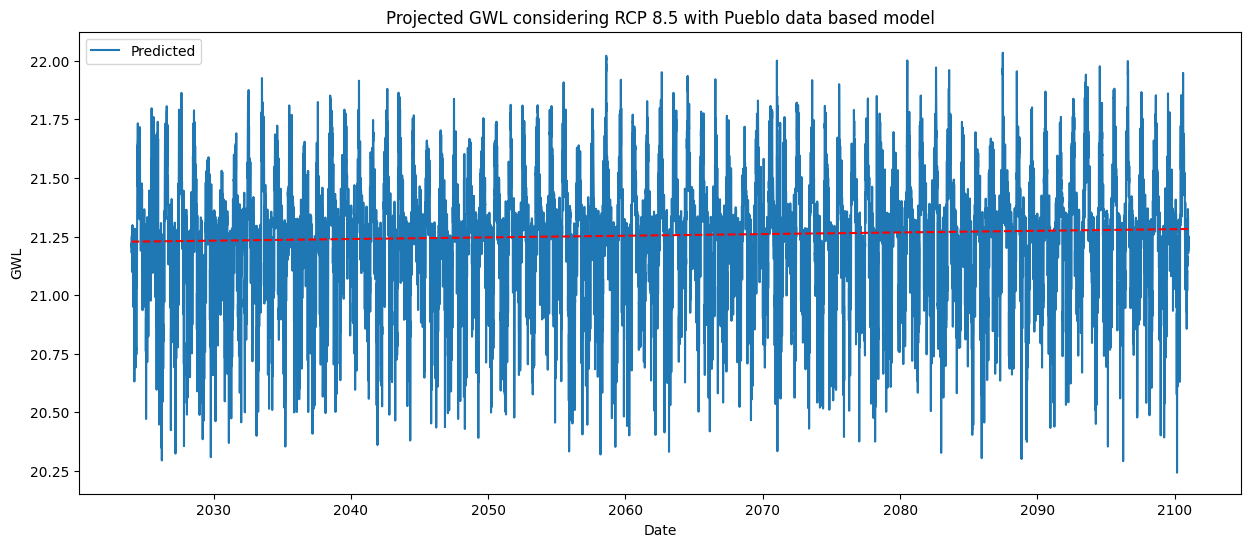

In [15]:
# load the scaler
sc_climate = load(open('model/sc_climate_pubelo.pkl', 'rb'))

x_transformed = sc_climate.transform(x)

# load the model
model = tf.keras.models.load_model('model/final_model_pueblo.h5')

y_pred = model.predict(x_transformed)

y_pred = [y[0] for y in y_pred]

df_projection = pd.DataFrame({'day_date': day_date, 'gwl': y_pred})

df_projection['day_date'] = pd.to_datetime(df_projection['day_date'])

trend_line = np.poly1d(np.polyfit(mdates.date2num(df_projection['day_date']), df_projection['gwl'], 1))

plt.figure(figsize=(15, 6))
plt.plot(df_projection['day_date'], df_projection['gwl'], label='Predicted')
plt.plot(mdates.date2num(df_projection['day_date']), trend_line(mdates.date2num(df_projection['day_date'])), "r--")
plt.title('Projected GWL considering RCP 8.5 with Pueblo data based model')
plt.xlabel('Date')
plt.ylabel('GWL')
plt.legend()
plt.show()